Sukces! Pobrano granice Elbląga.


<Axes: >

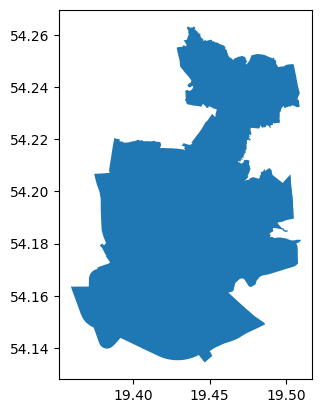

In [35]:
import geopandas as gpd
import requests
from shapely.geometry import shape
from urllib.parse import quote

# pobieranie granic administracyjnych
city_name = "Elbląg, Poland"
safe_city_name = quote(city_name)

# zapytanie do API Nominatim (OpenStreetMap) o geometrię poligonową
url = f"https://nominatim.openstreetmap.org/search?q={safe_city_name}&format=json&polygon_geojson=1"
headers = { 'User-Agent': 'MojaAplikacja' }
response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()
    if data:
        geom = shape(data[0]['geojson'])
        elblag_gdf = gpd.GeoDataFrame({'city': ['Elblag'], 'geometry': [geom]}, crs="EPSG:4326")
        print("Sukces! Pobrano granice Elbląga.")
        display(elblag_gdf.plot())
    else:
        print("Nie znaleziono takiego miasta.")
else:
    print(f"Błąd serwera: {response.status_code}")

In [36]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd

# odczyt CRS z przykładowego rastra
with rasterio.open('2025_B04.tiff') as src:
    raster_crs = src.crs
    print(f"Układ współrzędnych rastra to: {raster_crs}")

# reprojekcja granic miasta do układu rastra
elblag_matched = elblag_gdf.to_crs(raster_crs)
# przygotowanie maski
shapes = [elblag_matched.geometry.iloc[0].__geo_interface__]

print("Układy współrzędnych zostały dopasowane!")

Układ współrzędnych rastra to: EPSG:32634
Układy współrzędnych zostały dopasowane!


In [43]:
import os

# funkcja wczytuje raster, przycina go do maski i aktualizuje metadane transformacji
def get_cropped_raster(path, shapes):
    with rasterio.open(path) as src:
        # wycięcie obszaru i aktualizacja macierzy affine
        out_image, out_transform = mask(src, shapes, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        return out_image[0].astype('float32'), out_meta

years = range(2015, 2026)
results = []

for year in years:
    file_red = f"data/{year}_B04.tiff" # kanał czerwony
    file_nir = f"data/{year}_B08.tiff" # kanał bliskiej podczerwieni

    if os.path.exists(file_red) and os.path.exists(file_nir):
        try:
            # sprawdzenie CRS dla każdego roku (odporność na zmianę kafelków satelitarnych)
            with rasterio.open(file_red) as src:
                current_crs = src.crs
                current_shapes = [elblag_gdf.to_crs(current_crs).geometry.iloc[0].__geo_interface__]

            red, meta = get_cropped_raster(file_red, current_shapes)
            nir, _ = get_cropped_raster(file_nir, current_shapes)

            # obliczanie wskaźnika NDVI
            ndvi = (nir - red) / (nir + red + 1e-10)
            # piksele o NDVI > 0.4 klasyfikowane jako zieleń wysoka
            green_percentage = (np.sum(ndvi > 0.4) / np.sum(ndvi > -1)) * 100

            results.append({'rok': year, 'procent_zieleni': green_percentage})
            print(f"Rok {year}: Sukces ({green_percentage:.2f}%)")

        except ValueError:
            print(f"Rok {year}: Błąd! Granice Elbląga nie pokrywają się z tym zdjęciem.")
        except Exception as e:
            print(f"Rok {year}: Wystąpił inny błąd: {e}")
    else:
        print(f"Rok {year}: Brak plików.")

print("Analiza zakończona.")

Rok 2015: Sukces (45.00%)
Rok 2016: Sukces (47.18%)
Rok 2017: Sukces (46.86%)
Rok 2018: Sukces (45.94%)
Rok 2019: Sukces (46.70%)
Rok 2020: Sukces (44.99%)
Rok 2021: Sukces (47.01%)
Rok 2022: Sukces (47.90%)
Rok 2023: Sukces (47.34%)
Rok 2024: Sukces (45.95%)
Rok 2025: Sukces (48.26%)
Analiza zakończona.


Trend jest wzrostowy: miasto zyskuje średnio 0.16 punktu procentowego zieleni rocznie



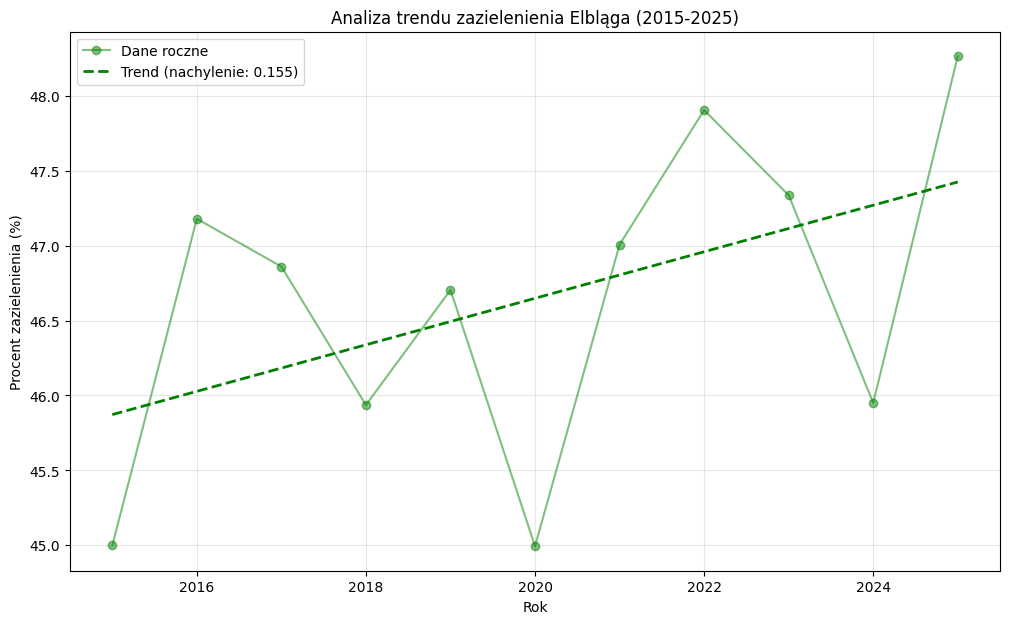

In [44]:
import numpy as np
import pandas as pd

results = pd.DataFrame(results)

x = results['rok'].values
y = results['procent_zieleni'].values

# regresja liniowa stopnia 1 (metoda najmniejszych kwadratów)
a, b = np.polyfit(x, y, 1)
a, b = np.polyfit(x, y, 1)
trend_line = a * x + b

# wizualizacja trendu zmian zazielenienia
plt.figure(figsize=(12, 7))
plt.plot(x, y, marker='o', color='green', label='Dane roczne', alpha=0.5)
plt.plot(x, trend_line, color='green', linestyle='--', linewidth=2, label=f'Trend (nachylenie: {a:.3f})')

plt.title('Analiza trendu zazielenienia Elbląga (2015-2025)')
plt.xlabel('Rok')
plt.ylabel('Procent zazielenienia (%)')
plt.legend()
plt.grid(True, alpha=0.3)

if a > 0:
    print(f"Trend jest wzrostowy: miasto zyskuje średnio {a:.2f} punktu procentowego zieleni rocznie\n")
elif a < 0:
    print(f"Trend jest spadkowy: miasto traci średnio {abs(a):.2f} punktu procentowego zieleni rocznie\n")
else:
    print("Brak wyraźnego trendu.")

plt.show()

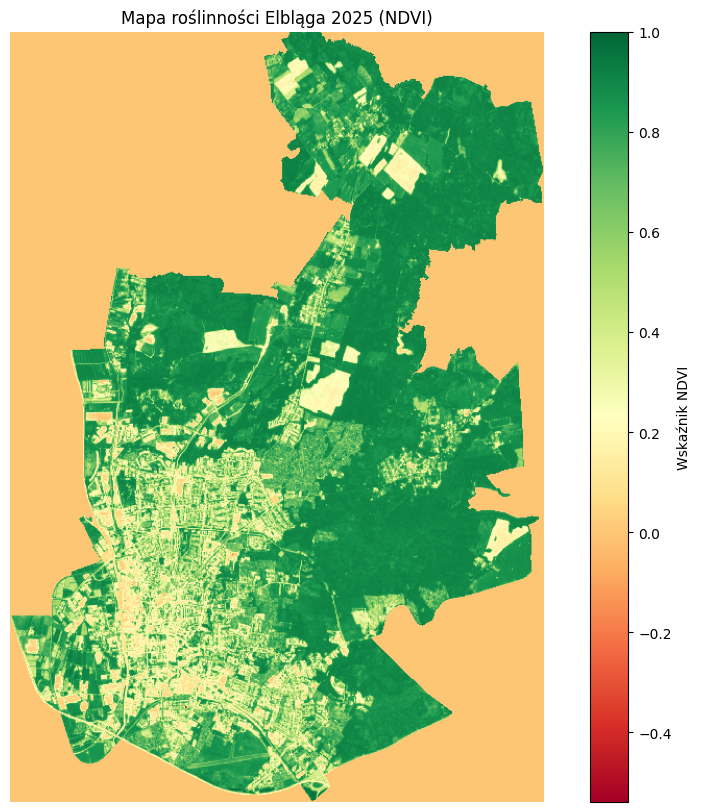

In [45]:
import matplotlib.pyplot as plt

# wizualizacja zazielenienia w roku 2025
plt.figure(figsize=(12, 10))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='Wskaźnik NDVI')
plt.title('Mapa roślinności Elbląga 2025 (NDVI)')
plt.axis('off')
plt.show()

In [46]:
# przygotowanie profilu metadanych dla pliku GeoTIFF
ndvi_meta = meta.copy()
ndvi_meta.update({
    "driver": "GTiff",
    "dtype": "float32",
    "count": 1
})

# zapis macierzy NDVI jako plik rastrowy z georeferencją
with rasterio.open('Elblag_NDVI_2025.tif', 'w', **ndvi_meta) as dst:
    dst.write(ndvi.astype('float32'), 1)

print("Plik Elblag_NDVI_2025.tif został zapisany!")

Plik Elblag_NDVI_2025.tif został zapisany!
